In [1]:
import numpy as np
import glob
import pandas as pd
pd.set_option('display.max_columns', 200)
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.linear_model import LinearRegression,HuberRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor



# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 6]
%config InlineBackend.figure_format='retina'

In [2]:
df = pd.read_csv(r'C:\Users\u23e00\NOx_prediction\data\raw\complete_data_29_10.csv')
df = df.drop('Unnamed: 0', axis=1)
df['NOx'] = df['GPiS_NO'] + df['GPiS_NO2']
df

,GPiS_NO,AMB_Humidity,AMB_Pressure,AMB_Temperature,EFM_AbsolutePressure,EFM_ExhaustGasDiffPress,EFM_ExhaustGasFlowMass,EFM_ExhaustGasFlowVol,EFM_ExhaustGasTemp,OBD_Accelerator_Pedal_Position_D_(PID_49),OBD_Barometric_Pressure_(PID_33),OBD_Engine_Coolant_Temperature_(PID_05),OBD_Engine_RPM_(PID_0C),OBD_Intake_Air_Temperature_(PID_0F),OBD_Vehicle_Speed_Sensor_(PID_0D),GPiS_NO2,accel,NOx
0,0.514287,31.845775,962.843895,21.151974,984.010010,0.00000,0.02200,0.000000,17.900000,14.9036,96.0,20.0,0.0,22.0,0.0,0.317213,NaN,0.831500
1,0.592000,31.918452,962.843895,21.181047,984.017822,0.00000,0.05398,0.000000,17.978001,14.9036,96.0,20.0,0.0,22.0,0.0,0.326000,0.0,0.918000
2,0.593300,31.894226,962.843895,21.151974,984.100220,0.00000,0.02171,0.000000,18.100000,14.9036,96.0,20.0,0.0,22.0,0.0,0.330225,0.0,0.923525
3,0.595300,31.845775,962.843895,21.122906,984.210022,0.00000,-0.04421,0.000000,18.100000,14.9036,96.0,20.0,0.0,22.0,0.0,0.336725,0.0,0.932025
4,0.596975,31.773098,962.843895,21.093832,984.210022,0.00000,-0.04077,0.000000,18.100000,14.9036,96.0,20.0,0.0,22.0,0.0,0.343225,0.0,0.940200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496225,0.182830,17.213895,974.436712,16.646320,976.128540,-0.00300,-1.28990,-0.000300,10.400000,14.8998,97.0,17.0,0.0,20.0,0.0,-0.883100,0.0,-0.700270
496226,0.171620,17.190055,974.675131,16.674925,976.190002,-0.00300,-1.38400,-0.000300,10.400000,14.8998,97.0,17.0,0.0,20.0,0.0,-0.878390,0.0,-0.706770
496227,0.160620,17.213895,974.436712,16.674925,976.190002,-0.00300,-1.34970,-0.000300,10.400000,14.8998,97.0,17.0,0.0,20.0,0.0,-0.873890,0.0,-0.713270
496228,0.149330,17.213895,974.675131,16.674925,976.197022,-0.00265,-1.21285,-0.000265,10.400000,14.8998,97.0,17.0,0.0,20.0,0.0,-0.869390,0.0,-0.720060


In [3]:
df = df[(df['GPiS_NO']<2500) &(df['GPiS_NO']>0)][:-2000]

In [4]:
channels_model = ['GPiS_NO','AMB_Humidity', 'AMB_Pressure', 'AMB_Temperature','EFM_ExhaustGasTemp','OBD_Engine_Coolant_Temperature_(PID_05)',
                  'OBD_Engine_RPM_(PID_0C)','OBD_Vehicle_Speed_Sensor_(PID_0D)','accel']

In [5]:
df = df[channels_model].dropna()
df = df[df['OBD_Engine_Coolant_Temperature_(PID_05)']>0]
df

,GPiS_NO,AMB_Humidity,AMB_Pressure,AMB_Temperature,EFM_ExhaustGasTemp,OBD_Engine_Coolant_Temperature_(PID_05),OBD_Engine_RPM_(PID_0C),OBD_Vehicle_Speed_Sensor_(PID_0D),accel
1,0.592000,31.918452,962.843895,21.181047,17.978001,20.0,0.00,0.0,0.0
2,0.593300,31.894226,962.843895,21.151974,18.100000,20.0,0.00,0.0,0.0
3,0.595300,31.845775,962.843895,21.122906,18.100000,20.0,0.00,0.0,0.0
4,0.596975,31.773098,962.843895,21.093832,18.100000,20.0,0.00,0.0,0.0
5,0.598475,31.797323,962.601614,21.122906,18.100000,20.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...
480447,18.639870,42.341800,976.820755,-4.895972,68.288002,95.0,1215.00,26.0,0.0
480448,17.270870,42.341800,976.820755,-4.867365,68.400002,95.0,1215.00,26.0,0.0
480449,17.113434,42.365642,977.059174,-4.867365,68.400002,95.0,1215.00,26.0,0.0
480450,16.955997,42.341800,976.820755,-4.867365,68.400002,95.0,1215.00,26.0,0.0


In [6]:
# convert time-series data to supervised data
def series_to_supervised(data, n_in, n_out=1, dropnan=True, col_name=df.columns):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for j in range(0,n_vars):
        for i in range(n_in[j], 0, -1):
            cols.append(df[j].shift(i))
            names += [(str(col_name[j]) + ' %d(t-%d)' % (j+1, i))]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(str(col_name[j]) +' %d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [(str(col_name[j]) +' %d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg, names

In [7]:
def split_data(data, n_lag, n_features,flag):
    n_obs = sum(n_lag)
    reframed = series_to_supervised(data, n_lag, 1)[0]
    if flag==1 :
        print(reframed.head())
    # split into train and test sets
    values = reframed.values
    n_train = int(train_percent*(len(data)))
    train = values[:n_train, :]
    test = values[n_train:, :]
    # split into input and outputs
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    print(train_X.shape, len(train_X), train_y.shape)
    print(test_X.shape)
    return train_X, train_y, test_X, test_y, series_to_supervised(data, n_lag, 1)[1]

In [8]:
def plot(y1,y2,title):
    x = []
    for i in range(0,len(y1)):
        x.append(i+1)
    plt.plot(x, y1, label = "Actual")   
    plt.plot(x, y2, label = "Predicted", color='C3') 
    plt.xlabel('Index') 
    plt.ylabel('NO Emission (ppm)') 
    plt.title(title) 
    plt.legend()    
    plt.show()

In [9]:
MSE = {}
train_percent =.9

n_lag = 20*(np.ones(df.shape[1]))
n_lag = list(map(int, n_lag))
n_features = df.shape[1]

# n_lag = []
# n_features = df.shape[1]
# for i in range(0,n_features):
#     if i%2==0:
#         n_lag.append(2)
#     else:
#         n_lag.append(3)

In [10]:
def xgb(data, n_lag, n_features,flag):
    # Fit Linear Regression
    train_X, train_y, test_X, test_y, columns = split_data(data, n_lag, n_features,flag)
    # include or exclude NO
#     train_X = pd.DataFrame(train_X).drop([0,1], axis=1).values
#     test_X = pd.DataFrame(test_X).drop([0,1], axis=1).values
    print("new_train shape :",len(train_X[0]))
    model = XGBRegressor(n_estimators=100)
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mse = np.sqrt(mean_squared_error(prediction, test_y))
    return prediction, mse,test_y, model,train_X,test_X, columns

    GPiS_NO 1(t-20)  GPiS_NO 1(t-19)  GPiS_NO 1(t-18)  GPiS_NO 1(t-17)  \
20         0.592000         0.593300         0.595300         0.596975   
21         0.593300         0.595300         0.596975         0.598475   
22         0.595300         0.596975         0.598475         0.600300   
23         0.596975         0.598475         0.600300         0.602300   
24         0.598475         0.600300         0.602300         0.604300   

    GPiS_NO 1(t-16)  GPiS_NO 1(t-15)  GPiS_NO 1(t-14)  GPiS_NO 1(t-13)  \
20         0.598475          0.60030          0.60230         0.604300   
21         0.600300          0.60230          0.60430         0.606300   
22         0.602300          0.60430          0.60630         0.608150   
23         0.604300          0.60630          0.60815         0.610000   
24         0.606300          0.60815          0.61000         0.610325   

    GPiS_NO 1(t-12)  GPiS_NO 1(t-11)  GPiS_NO 1(t-10)  GPiS_NO 1(t-9)  \
20         0.606300         0.608150 

new_train shape : 180


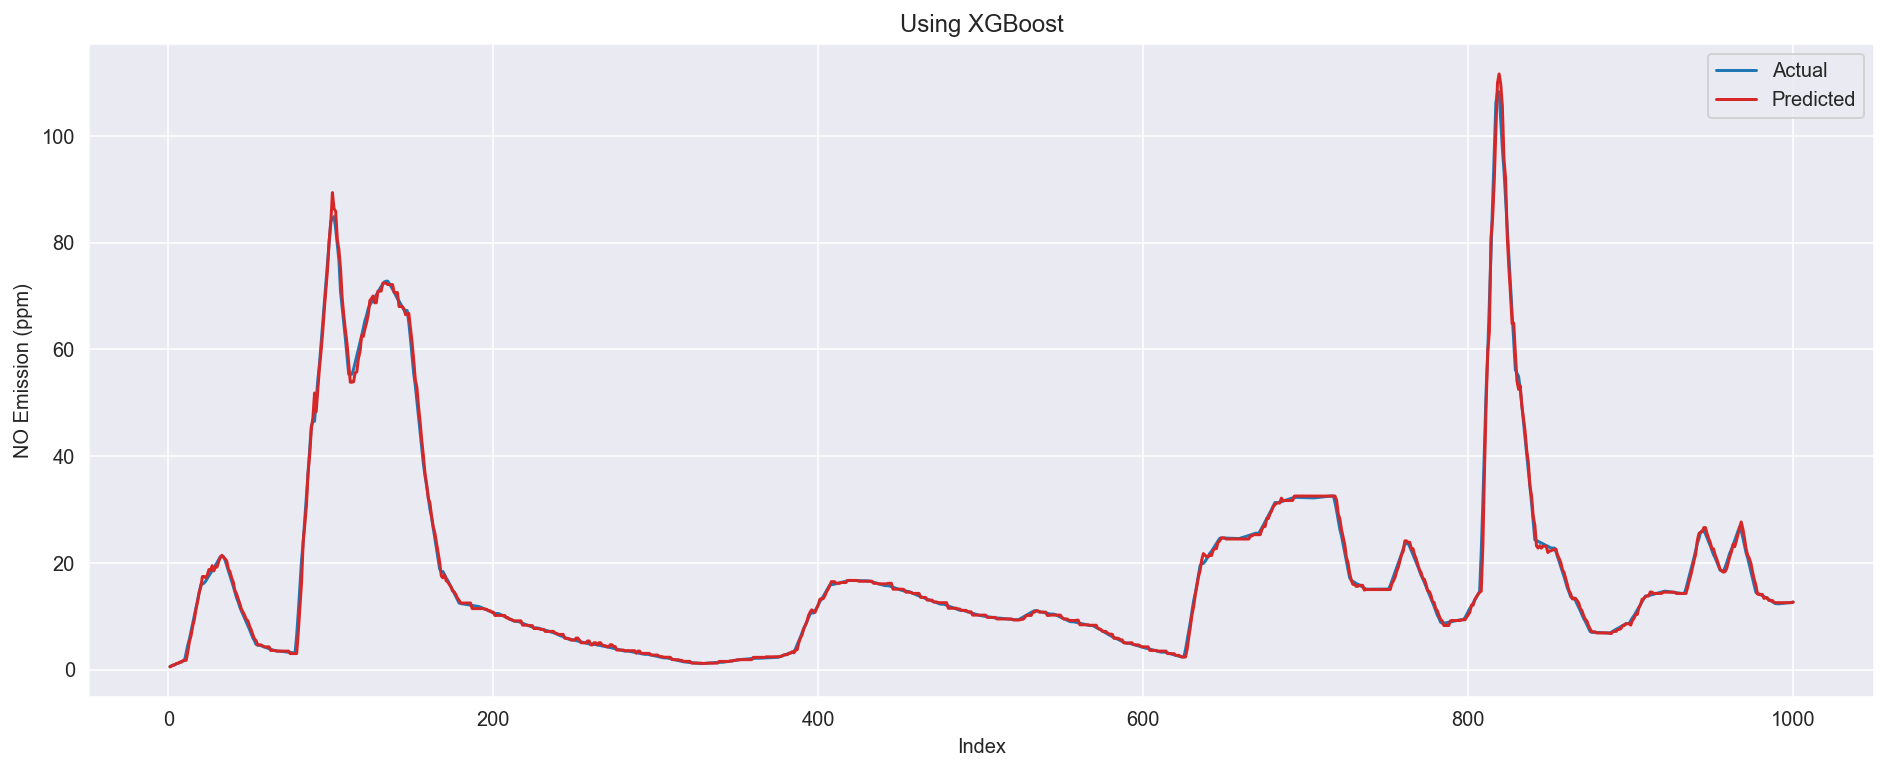

In [11]:
prediction_xgb, MSE['XGB'],test_xgb, model_xgb, train_X,test_X, columns = xgb(df.values, n_lag, n_features, 1)
plot(test_xgb[5000:6000], prediction_xgb[5000:6000], 'Using XGBoost')

In [23]:
np.sqrt(mean_squared_error(prediction_xgb, test_xgb))

4.915777014424527

In [12]:
from xgboost import plot_importance
# # plot feature importance
# # model_xgb.get_booster().feature_names = columns
# plt.figure(figsize=(15,8))
# plot_importance(model_xgb, max_num_features = 25);

# Validation on others data

In [13]:
df_others = pd.read_csv(r'C:\Users\u23e00\NOx_prediction\data\raw\others_data.csv')
df_others = df_others.drop('Unnamed: 0', axis=1)
df_others['NOx'] = df_others['GPiS_NO'] + df_others['GPiS_NO2']
df_others

,GPiS_NO,GPiS_NO2,AMB_Humidity,AMB_Pressure,AMB_Temperature,EFM_ExhaustGasTemp,OBD_Engine_Coolant_Temperature_(PID_05),OBD_Engine_RPM_(PID_0C),OBD_Vehicle_Speed_Sensor_(PID_0D),accel,NOx
0,-0.060000,0.189700,49.001908,972.588635,22.011402,24.700001,21.0,0.0,0.0,NaN,0.129700
1,-0.076000,0.187000,49.025788,971.872330,22.011402,24.700001,21.0,0.0,0.0,0.0,0.111000
2,-0.081500,0.185900,49.001908,972.111082,22.011402,24.700001,21.0,0.0,0.0,0.0,0.104400
3,-0.094000,0.183400,48.978033,972.111082,22.011402,24.700001,21.0,0.0,0.0,0.0,0.089400
4,-0.129380,0.182220,48.978033,972.111082,22.011402,24.700001,21.0,0.0,0.0,0.0,0.052840
...,...,...,...,...,...,...,...,...,...,...,...
227178,-1.831735,6.136540,76.198182,960.000000,22.500000,80.199997,96.0,0.0,0.0,0.0,4.304805
227179,-1.826235,6.134540,76.198182,960.000000,22.500000,77.199997,96.0,0.0,0.0,0.0,4.308305
227180,-1.820620,6.132425,76.198182,960.000000,22.500000,77.199997,96.0,0.0,0.0,0.0,4.311805
227181,-1.814620,6.129925,76.198182,960.000000,22.500000,77.199997,96.0,0.0,0.0,0.0,4.315305


In [14]:
channels_model = ['GPiS_NO','AMB_Humidity', 'AMB_Pressure', 'AMB_Temperature','EFM_ExhaustGasTemp','OBD_Engine_Coolant_Temperature_(PID_05)',
                  'OBD_Engine_RPM_(PID_0C)','OBD_Vehicle_Speed_Sensor_(PID_0D)','accel']

In [15]:
df_others = df_others[channels_model].dropna()
df_others = df_others[df_others['OBD_Engine_Coolant_Temperature_(PID_05)']>0]
df_others = df_others[(df_others['GPiS_NO']<2500) &(df_others['GPiS_NO']>0)]
df_others

,GPiS_NO,AMB_Humidity,AMB_Pressure,AMB_Temperature,EFM_ExhaustGasTemp,OBD_Engine_Coolant_Temperature_(PID_05),OBD_Engine_RPM_(PID_0C),OBD_Vehicle_Speed_Sensor_(PID_0D),accel
17,0.550720,49.001908,971.872330,22.040058,24.700001,21.0,0.0,0.0,0.0
18,1.451000,49.025788,971.872330,22.011402,24.700001,21.0,0.0,0.0,0.0
19,2.351000,49.001908,971.633577,22.011402,24.700001,21.0,0.0,0.0,0.0
20,3.503500,48.978033,971.633577,21.982752,24.700001,21.0,0.0,0.0,0.0
21,4.656000,49.001908,972.111082,22.011402,24.700001,21.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
227093,0.378000,76.317568,960.000000,22.500000,81.199997,96.0,0.0,0.0,0.0
227094,0.356150,76.245933,960.000000,22.500000,81.199997,96.0,0.0,0.0,0.0
227095,0.261150,76.245933,960.000000,22.500000,81.199997,96.0,0.0,0.0,0.0
227096,0.166265,76.269813,960.000000,22.500000,81.199997,96.0,0.0,0.0,0.0


In [16]:
pred, MSE['XGB'],test, model,train_X1,test_X1, columns = xgb(df_others.dropna().values, n_lag, n_features,0)

(196886, 180) 196886 (196886,)
(21857, 180)
new_train shape : 180


In [17]:
prediction = model_xgb.predict(test_X1)

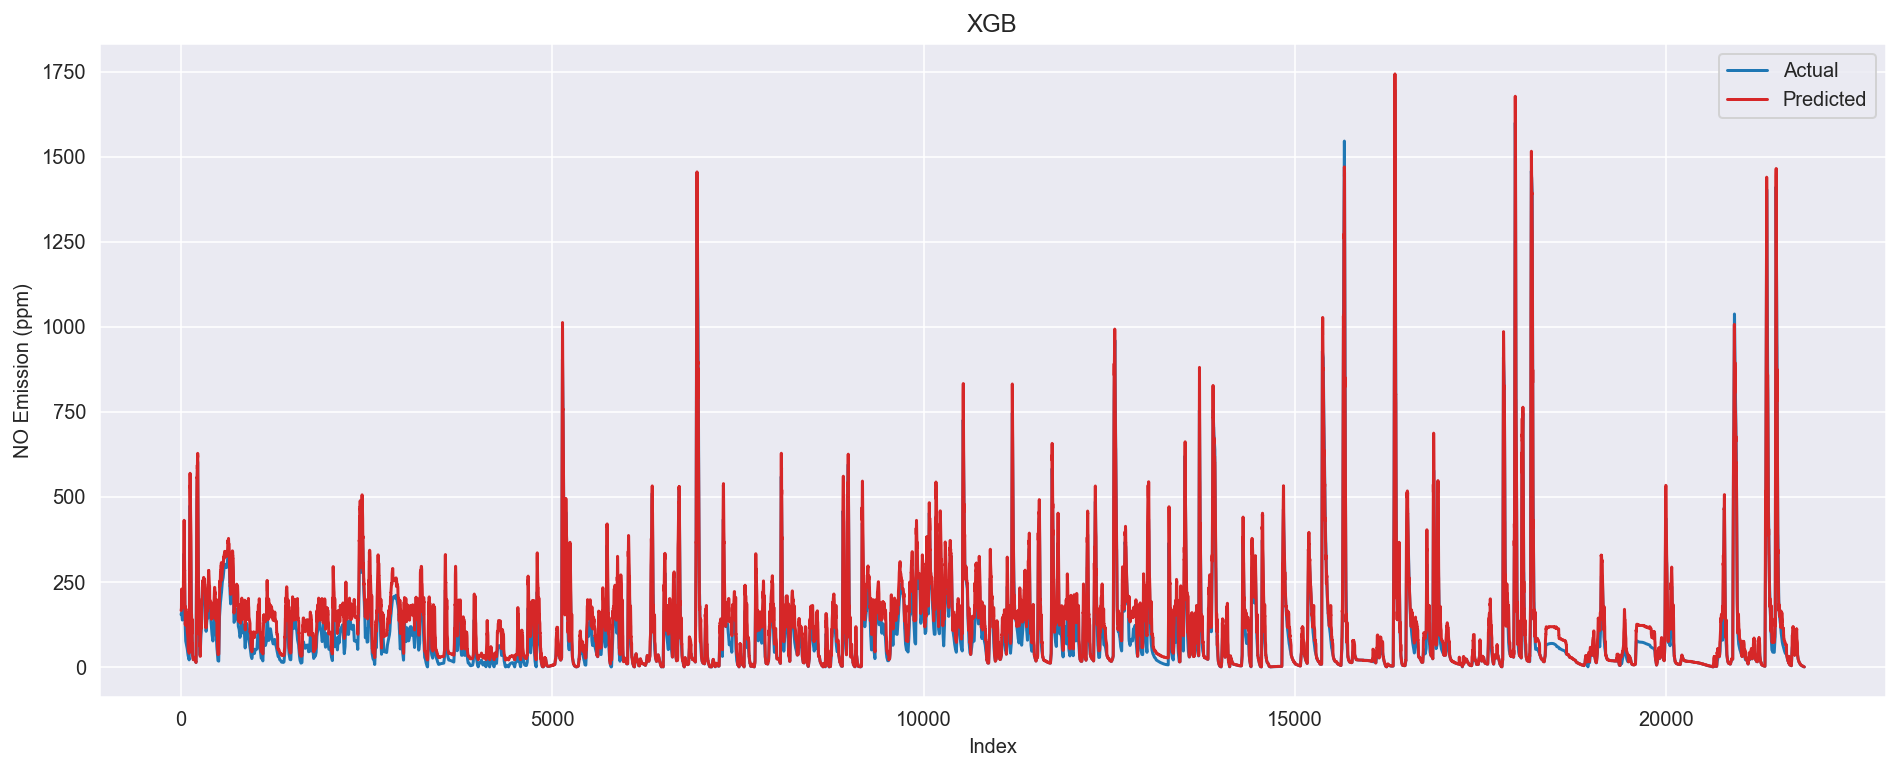

In [18]:
plot(test, prediction, 'XGB')

In [19]:
np.sqrt(mean_squared_error(pred, test))

7.167935428122398

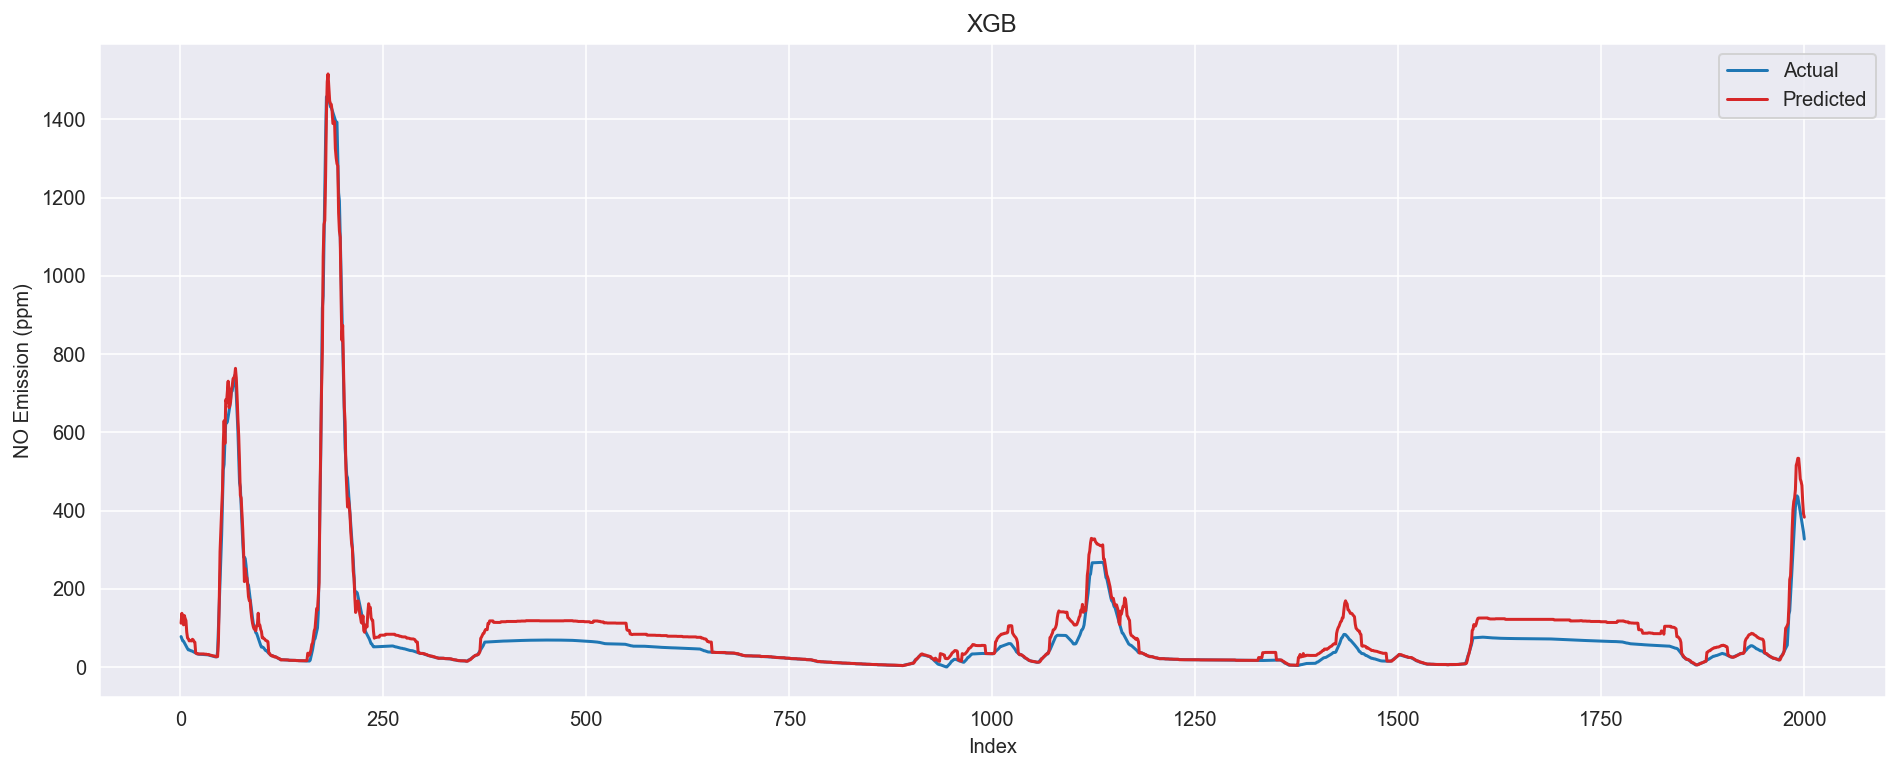

In [25]:
plot(test[18000:20000], prediction[18000:20000], 'XGB')

In [21]:
# import joblib
# #save model
# joblib.dump(model_xgb, 'xgb_model') 

# #load saved model
# xgb = joblib.load('xgb_model')

<Figure size 1080x648 with 0 Axes>

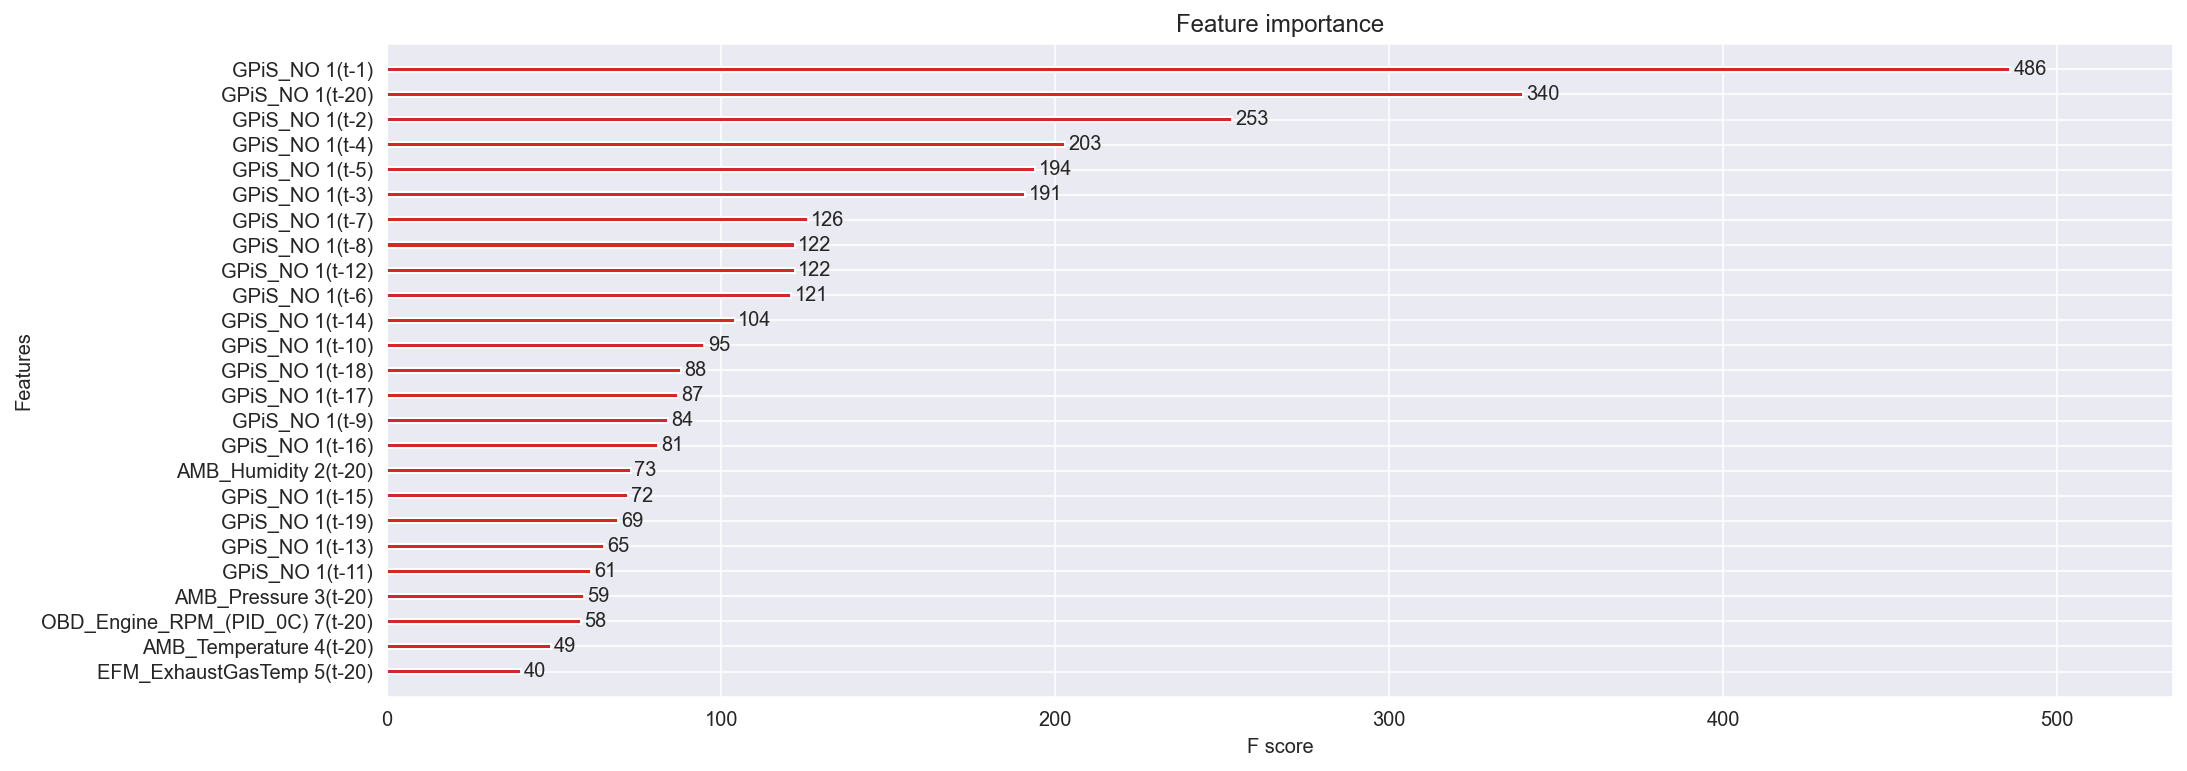

In [29]:
from xgboost import plot_importance
# plot feature importance
model_xgb.get_booster().feature_names = columns
plt.figure(figsize=(15,9))
plot_importance(model_xgb, max_num_features = 25, color='C3');